Homework 2 — (15 points)
======
### What to hand in
You are to submit the following things for this homework:
1. A Jupyter notebook containing all code and output (figures and audio). I should be able to evaluate the file to reproduce all output. 
1. Any other data that we tell you to save to a file (e.g. audio files).

### How to hand it in
To submit your lab:
1. Compress all of the files specified into a .zip file. 
1. Name the file in the following manner, firstname_lastname_hw1.zip. For example, Bryan_Pardo_hw1.zip. 
1. Submit this .zip file via Canvas

## Run this code block 1st, to import some needed packages

In [1]:
# This line is a convenience to import most packages you'll need. You may need to import others (eg random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

# Feel free to add some other imports here, if that is helpful



/Users/Atul/miniconda2/envs/eecs352/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


## Implementing a spectrogram 

#### 1. (2 points) Make a short term Fourier transform (STFT) function.  

In [2]:
from scipy.fftpack import fft
from scipy.signal import hann
import math

def stft(signal, window_size, hop_size, window_type = 'hann'):

    no_columns = int(math.floor((len(signal)-hop_size)/hop_size))
    no_rows =  window_size
    
        
#     print signal

    final_matrix = np.zeros(shape=(no_rows,no_columns),dtype=np.complex)
#     final_matrix=[]

    hop_index = 0
    desired_signal =[]
    temp_hann=[]
    
    
    for i in range(no_columns):
        hop_index = i*hop_size
        desired_signal=signal[hop_index:hop_index + window_size]
        
        if window_type=='hann':
            hann_multiplier=hann(window_size)
        else:
            hann_multiplier =1

        temp_hann =fft(hann_multiplier * desired_signal)
        
        final_matrix[:,i]=np.transpose(temp_hann)

    return final_matrix
    
    
def make_sinewave(f, t, sr):
    
    y = np.arange(0,t*sr)/float(sr)
    x = np.sin(2*np.pi*f*y)
    return x
        

y=make_sinewave(2.,1.,1000.)       
mat = stft(y,100,50)




#### 2. (2 points) 
1. **Make a signal $S$ of length 300 that has 1 for every one of its 300 samples.** 
1. **Make a signal $W_1$ by windowing this signal with a Hann window of length 200, starting at index 0.**  
1. **Make signal $W_2$ by windowing this signal with a Hann window of length 200, starting at index 100.** 
1. **Now....make a reconstruction of $S$ from $W_1$ and $W_2$ by overlapping the two windowed signals 50% (the same way you took them from $S$ and adding them together....where $W_1[100]$ would aling with $W_2[0]$. This is called "overlap and add." **

**How much does the reconstructed signal look like the original? What happens if these windows are not overlapped 50%, but by some other amount?**   

Yes, it does look like the original signal (it has a flat top in the middle). If I change the overlap to different values, it doesn't look the same. See graphs below:

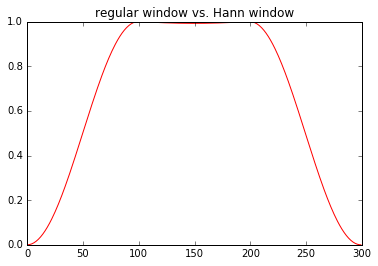

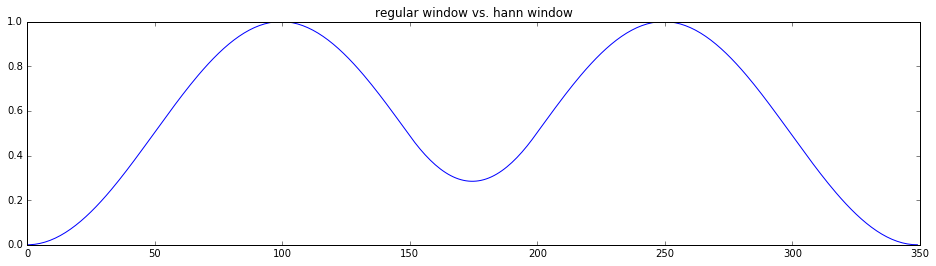

In [3]:
#---------------------
# your code goes below
#---------------------
length_a=300
length_b = 200
S = np.ones(length_a)
window = hann(length_b)
temp=[]


for i in range(200):
    temp=S[i]*window
    

# print temp
W1= np.concatenate((temp, [0]*100))
    
W2 =np.concatenate(([0]*100,temp))

result = W1 + W2

#Overlapped 50%
plt.plot(result,'r')
plt.title("regular window vs. Hann window")





W7 = np.concatenate(([0]*150,temp))
W8 = np.concatenate((temp,[0]*150))

result3 = W7 + W8
plt.figure(figsize=(16,4))
plt.plot(result3)
plt.title("regular window vs. hann window")


    

#### 3. (2 points) Make an inverse STFT function to rebuild the original audio signal, using overlap & add resynthesis. You don't need to use a window function here.

/Users/Atul/miniconda2/envs/eecs352/lib/python2.7/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


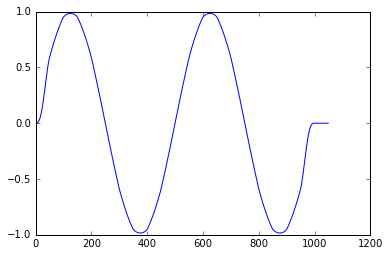

In [4]:
from scipy.fftpack import ifft

def istft(X, hop_size):
    """
    Takes a 2-D numpy array representing an STFT of some signal, where stft[i] 
    is the FFT of the ith window as input and stft[i,k] is the kth frequency of analysis.
    Performs an inverse FFT on each window and then does overlap & add resynthesis to rebuild 
    the original signal the STFT was built from.
    
    Input Parameters
    ----------------
    X: a 2-D numpy array of complex numbers representing an STFT, where the ith 
    column is the FFT of the ith window, and the jth row is the jth frequency of analysis.
        
    hop_size: an integer specifying the number of samples between the start of adjacent windows.
        
    Returns
    -------
    a 1-d numpy array of (possibly complex) values representing the original signal used to make X
    """
    #---------------------
    # your code goes below
    #---------------------
    
    no_rows, no_cols = X.shape

    signal = np.zeros(no_cols*hop_size+no_rows,dtype=complex)
    
    
    for i in range(no_cols):
        temp_ifft = ifft(X[:, i]).T
        signal[i*hop_size : i*hop_size + temp_ifft.size] += temp_ifft
        
        
#     plt.plot(signal,'-b')
    
#     print signal
    return signal
        



p =istft(mat,50)
plt.plot(p)

#### 4. (2 points) Display a magnitude spectrogram of an audio signal. Amplitude must be in dB. Correct frequencies must be displayed. Display only frequencies up to the Nyquist rate.  Time must be displayed in seconds. NOTE: you cannot use any functions in librosa to do this.

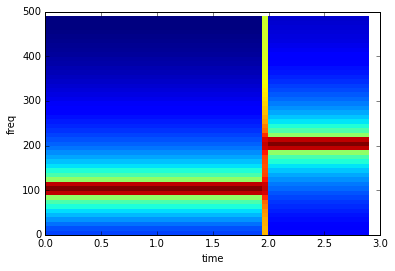

In [5]:
# convert intensity to decibels
to_db = lambda x : 20 * np.log10(abs(x))

def spectrogram(signal, window_size, hop_size, sample_rate, window_type = 'hann', display = 1 ):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This creates a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    It then creates a magnitude spectrogram of the signal and plots it on the screen.
    Here, the vertical dimension is frequency (in Hz), the horizontal dimension is time
    (in seconds), brightness corresponds to amplitude (in dB). Only frequencies up to
    the Nyquist rate are displayed.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    window_type: a string specifying one of two "hann" or "rectangular"
    display: an integer. If set to 1, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with 3 items
    
    sgram:  a 2-D numpy array of real-valued numbers that contains the magnitude spectrogram
           sgram[t,f] is the magnitude at time t and frequency f. This only contains values
           up to the nyquist frequency
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    freqs: a 1-D numpy array  of non-negative real values. freqs[f] gives the fth
           frequency of analysis in Hz, up to the nyquist frequency
           
    Calling Example
    ---------------
    sgram,times,freqs = spectrogram(signal, window_size, hop_size, sample_rate )

    """ 
    #---------------------
    # your code goes below
    #---------------------
    
    mat_new = stft(signal, window_size, hop_size, window_type)
    no_rows = mat_new.shape[0]
    no_cols = mat_new.shape[1]
    sample_rate = float(sample_rate)
    sample_spacing = 1 / sample_rate
    freqs = (np.arange(no_rows) * (sample_rate / window_size))[: no_rows / 2]    
    times = np.arange(0, no_cols * hop_size / sample_rate, hop_size / sample_rate)                   
    sgram = to_db(mat_new)
    ny_sgrm = sgram[:no_rows / 2,:]          
    
    if display==1:
        t, f = np.meshgrid(times, freqs) 
        plt.pcolormesh(t, f, ny_sgrm)
        plt.xlabel('time')
        plt.ylabel('freq')
        
    return ny_sgrm, times, freqs


    

signal = np.concatenate((make_sinewave(100, 2, 1000), make_sinewave(200, 1, 1000)))
sgram, times, freqs = spectrogram(signal, 100, 50, 1000);
    

## Manipulating audio

#### 5. (1 point) Now increase the speed of playback for file piano.wav by the same amount as in the previous question....but don't change the pitch. (again, don't use librosa)

In [6]:
#---------------------
# your code goes below
#---------------------
from IPython.display import Audio
import scipy.io.wavfile

def wavwrite(filepath, data, sr, norm=True, dtype='int16',):
    '''
    Write wave file using scipy.io.wavefile.write, converting from a float (-1.0 : 1.0) numpy array to an integer array
    
    Parameters
    ----------
    filepath : str
        The path of the output .wav file
    data : np.array
        The float-type audio array
    sr : int
        The sampling rate
    norm : bool
        If True, normalize the audio to -1.0 to 1.0 before converting integer
    dtype : str
        The output type. Typically leave this at the default of 'int16'.
    '''
    if norm:
        data /= np.max(np.abs(data))
    data = data * np.iinfo(dtype).max
    data = data.astype(dtype)
    scipy.io.wavfile.write(filepath, sr, data)





sr =44100.
piano_wave, sr = librosa.load('piano.wav', sr=sr, duration=11)

window_size =100
hop_size = 50
piano_reconstructed = stft(piano_wave,window_size,hop_size)
#Increase the hop size by 25% to increase the speed of playback
# piano_reconstructed = piano_reconstructed.real
piano_istft = istft(piano_reconstructed,hop_size-hop_size*.25)









IPython.display.display(Audio(piano_istft, rate=sr))
IPython.display.display(Audio(piano_wave,rate=sr))
wavwrite('Speeded.wav', piano_istft, sr, norm=True)

/Users/Atul/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Atul/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Atul/miniconda2/envs/eecs352/lib/python2.7/site-packages/IPython/lib/display.py:123: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


/Users/Atul/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


#### 6. (1 point) Now increase the pitch of file piano.wav by  two musical whole steps without changing the duration of the audio. (again.... don't use librosa)

In [7]:
from IPython.display import Audio


#---------------------
# your code goes below
#---------------------
    
    #Since we want to increase the pitch by two musical whole steps, n=2
n=2
factor_pitch = 2**(n / 12.0) 
sr = 44100
piano_wave, sr = librosa.load('piano.wav', sr, duration=11)

#Algorithm: We should double the length without affecting the pitch and we should play it twice as fast
piano_reconstructed2 = stft(piano_wave,50,50)
piano_istft_2 = istft(piano_reconstructed2,50)


#Play the audio at this sampling rate = factor_pitch
Audio(piano_istft_2, rate=factor_pitch*sr)
wavwrite('pitch_shifted.wav', piano_istft_2, sr, norm=True)


/Users/Atul/miniconda2/envs/eecs352/lib/python2.7/site-packages/ipykernel/__main__.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


## Log Frequency 

#### 7. ( 2 points) Write a function that emulates triangular filters in the frequency domain. This function will be used to map from the linearly spaced frequencies of the STFT to another specified set of frequencies, with arbitrary spacing.



In [8]:
def make_triangular_filters(cfreqs, freqs ):
    """
    Computes a set of "filters" to apply to an STFT to change its frequency scaling.
    This takes an array of center frequencies (cfreqs) and a set of frequencies of 
    analysis (freqs) as input, both coded in Hz.  It will return a 2-D numpy array 
    filters[c][f], where c is the index number of a center frequency in cfreqs and 
    f is the index to a frequency in freqs and the value in filters[c][f] is a number 
    between 0 and 1 that represents how sensitive this filter is to that frequency.  
    Filters are triangular, with a linear decrease in sensitivity from the center 
    frequency (sensitivity = 1) down to a sensitivity of 0 by the center frequency 
    of each adjacent freqency.
    
    Input Parameters
    ----------------
    cfreqs: a 1-D python array of center frequencies measured in Hz
    freqs:   a 1-D python array of frequencies for whom we need to calculate the sensitivity
             of each filter
    
    Returns
    -------
    filters: a 2-D numpy array, where c is the index number of a center frequency in 
            cfreqs and f is the index to a frequency in freqs and the value in filters[c][f] 
            is a number between 0 and 1 that represents how sensitive this filter is to 
            that frequency.
    """
    #---------------------
    # your code goes below
    #---------------------
    
    filters = np.zeros((len(cfreqs), len(freqs)))
    low_range = 0
    for i in range(len(cfreqs)):
        peak = cfreqs[i]
        high_range = (peak - low_range) + peak
        for j in range(len(freqs)):
            slope = 1.0 / (peak-low_range) if freqs[j] < peak else 1.0 / (peak-high_range)
            filters[i][j] = max(slope * (freqs[j] - peak) + 1, 0)
        low_range = peak

    return filters
   

    

#### 8. (1 point) You have been given a set of input frequencies spaced 1 Hz apart and ranging from the bottom piano note to the top note...and a second set of a center frequencies that are spaced with 1 per key on the piano. Use your code from problem 7 to create a filterbank, mapping the energy from the first set of frequencies to the second set of frequencies. Then display the filterbank as a 2-D image where the vertical dimension is freq in Hz, the horizontal dimension is the index of a filter (i.e. the piano key number) and the color gives the strength of the filter response. Label your dimensions. Also, give a list of the piano key frequencies below the plot. 

27.5


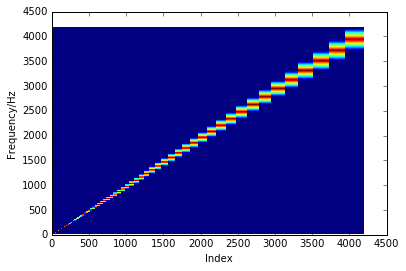

[   27.5           29.13523509    30.86770633    32.70319566    34.64782887
    36.70809599    38.89087297    41.20344461    43.65352893    46.24930284
    48.9994295     51.9130872     55.            58.27047019    61.73541266
    65.40639133    69.29565774    73.41619198    77.78174593    82.40688923
    87.30705786    92.49860568    97.998859     103.82617439   110.
   116.54094038   123.47082531   130.81278265   138.59131549   146.83238396
   155.56349186   164.81377846   174.61411572   184.99721136   195.99771799
   207.65234879   220.           233.08188076   246.94165063   261.6255653
   277.18263098   293.66476792   311.12698372   329.62755691   349.22823143
   369.99442271   391.99543598   415.30469758   440.           466.16376152
   493.88330126   523.2511306    554.36526195   587.32953583   622.25396744
   659.25511383   698.45646287   739.98884542   783.99087196   830.60939516
   880.           932.32752304   987.76660251  1046.5022612   1108.73052391
  1174.65907167  1244

In [9]:
# A440 is 39 keys from the top of the piano and 44 keys from the bottom
top_piano_note =  440*2**(39.0/12)
bottom_piano_note = 440*2**(-48.0/12)
print bottom_piano_note

# our frequencies will be spaced 1 Hz appart in this domain
freqs = np.linspace(bottom_piano_note,top_piano_note,(top_piano_note-bottom_piano_note + 1))

# our center frequencies will be spaced with one per piano note
cfreqs = bottom_piano_note * np.logspace(0, 87.0/12, 88, base=2)

#---------------------
# your code goes below
#---------------------
output_temp = make_triangular_filters(cfreqs, freqs)
output = np.transpose(output_temp)
index, frequency = np.meshgrid(cfreqs, freqs)
plt.pcolormesh(index, frequency, output)
plt.xlabel('Index')
plt.ylabel('Frequency/Hz')
plt.show()
print cfreqs

#### 9. (2 point)  Use the mapping from frequency $f$ to mel $m$ defined in (1) to make a mel-frequency filter bank with 40 filters, evenly spaced in mels, that covers the same range as the piano-note spaced filterbank.  Display a plot of it. Give a list of the mel frequencies (in Hz). Do you think this number of filters and spacing appropriately captures the salient aspects of music? Why or why not?

$m = 2595log_{10}(1+\frac{f}{700})$

(1) Douglas O'Shaughnessy (1987). Speech communication: human and machine. Addison-Wesley. p. 150. ISBN 978-0-201-16520-3.

Yes, the number of filters and spacing appropriately captures the salient aspects of the music. The 40 filters are narrow but they cover the range of keyboard frequencies pretty evenly. The the top is not entirely flat, but it is very close to being flat because the filters are very close to each other. Thus, this closely spaced filters would capture the salient aspects of music.    

[   43.42721509    68.09824604    92.76927699   117.44030794   142.1113389
   166.78236985   191.4534008    216.12443175   240.79546271   265.46649366
   290.13752461   314.80855556   339.47958652   364.15061747   388.82164842
   413.49267937   438.16371033   462.83474128   487.50577223   512.17680318
   536.84783414   561.51886509   586.18989604   610.860927     635.53195795
   660.2029889    684.87401985   709.54505081   734.21608176   758.88711271
   783.55814366   808.22917462   832.90020557   857.57123652   882.24226747
   906.91329843   931.58432938   956.25536033   980.92639128  1005.59742224
  1030.26845319  1054.93948414  1079.61051509  1104.28154605  1128.952577
  1153.62360795  1178.2946389   1202.96566986  1227.63670081  1252.30773176
  1276.97876272  1301.64979367  1326.32082462  1350.99185557  1375.66288653
  1400.33391748  1425.00494843  1449.67597938  1474.34701034  1499.01804129
  1523.68907224  1548.36010319  1573.03113415  1597.7021651   1622.37319605
  1647.044227  

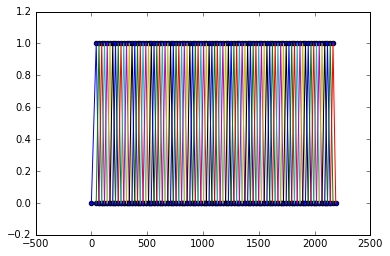

In [12]:
#---------------------
# your code goes below
#---------------------

#Given formula
upper_bound = 2595 * np.log10(1 + top_piano_note / 700)
lower_bound = 2595 * np.log10(1 + bottom_piano_note / 700)
intervals = np.linspace(lower_bound, upper_bound, 88)
print intervals

left=0
for i, middle in enumerate(intervals[:intervals.size-1]):
    triangle_coordinates = [left, middle, intervals[i+1]]
#     print triangle_coordinates
    amplitude = [0,1,0]
    plt.scatter(triangle_coordinates,amplitude)
    plt.plot(triangle_coordinates, amplitude)
    left = middle

